# XGBoost classifier

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import xgboost
import numpy as np
import cupy as cp
import pandas as pd
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from hyperopt import fmin, tpe, hp, Trials

import configuration as config

/mnt/arkk/llm_detector/classifier


In [33]:
# Load the raw training and testing data
training_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF)
testing_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TESTING_DATA_PR_TFIDF)

percent_human_fragments = (len(training_data_df[training_data_df['Source'] == 'human']) / len(training_data_df)) * 100
print(f'Text fragments are {percent_human_fragments}% human\n')

training_data_df.info()
print()
training_data_df.head()

Text fragments are 73.11331474021279% human

<class 'pandas.core.frame.DataFrame'>
Index: 96810 entries, 0 to 96809
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (tokens)                 96810 non-null  int64  
 1   Dataset                                  96810 non-null  object 
 2   Source                                   96810 non-null  object 
 3   String                                   96810 non-null  object 
 4   Perplexity                               96810 non-null  float64
 5   Cross-perplexity                         96810 non-null  float64
 6   Perplexity ratio score                   96810 non-null  float64
 7   Perplexity ratio Kullback-Leibler score  96810 non-null  float64
 8   Human TF-IDF                             96810 non-null  float64
 9   Synthetic TF-IDF                         96810 non-null  float64
 10  TF-IDF

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score
0,179,pubmed-falcon7,human,"\n age , sex , final education , the average m...",2.549562,2.746482,0.928301,0.249962,-2.639094,-2.541294,0.506643,0.103827
1,227,cnn-llama2-13,synthetic,we are seeing this season is a far cry from th...,2.594488,3.453265,0.751314,1.482401,-3.447403,-3.272191,1.177354,0.047752
2,244,cnn-llama2-13,human,been performed for thousands of years. In some...,2.951859,3.093754,0.954135,0.144317,-3.362655,-3.035911,2.090690,0.030318
3,178,cc_news-llama2-13,human,or machinations in the 2016 campaign as ground...,2.474184,3.026876,0.817405,1.516302,-3.206865,-3.077414,0.813506,0.077268
4,173,pubmed-llama2-13,human,progenitor cell and one postmitotic neuron ....,2.665275,2.825413,0.943322,0.177392,-3.182795,-2.988648,1.198170,0.046413


In [34]:
# Split the data into features and labels
labels_train_df = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)
labels_test_df = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train_df)
labels_train = label_encoder.transform(labels_train_df)

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_test_df)
labels_test = label_encoder.transform(labels_test_df)

In [35]:
# Keep dataframe copy for easy manipulation later and make a numpy copy for training
# without the dataset or string columns
features_train = features_train_df.drop(['Dataset', 'String'], axis = 1).to_numpy()
features_test = features_test_df.drop(['Dataset', 'String'], axis = 1).to_numpy()
# labels_train = labels_train_df.to_numpy()
# labels_test = labels_test_df.to_numpy()

print(f'Training data: {len(features_train)} examples')
print(f'Test data: {len(features_test)} examples')
print()
print('Training features:')
print(features_train_df.info())
print()
print('Training labels:')
print(labels_train)

Training data: 96810 examples
Test data: 24202 examples

Training features:
<class 'pandas.core.frame.DataFrame'>
Index: 96810 entries, 0 to 96809
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (tokens)                 96810 non-null  int64  
 1   Dataset                                  96810 non-null  object 
 2   String                                   96810 non-null  object 
 3   Perplexity                               96810 non-null  float64
 4   Cross-perplexity                         96810 non-null  float64
 5   Perplexity ratio score                   96810 non-null  float64
 6   Perplexity ratio Kullback-Leibler score  96810 non-null  float64
 7   Human TF-IDF                             96810 non-null  float64
 8   Synthetic TF-IDF                         96810 non-null  float64
 9   TF-IDF score                             9681

## Off-the-shelf XGBoost classifier

In [36]:
# Fit model on training data
model = xgboost.XGBClassifier()
model.fit(features_train, labels_train)

# Make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 86.5%



Confusion matrix:
[[16423  1388]
 [ 1871  4520]]

Normalized confusion matrix:
[[0.67858028 0.05735063]
 [0.07730766 0.18676142]]



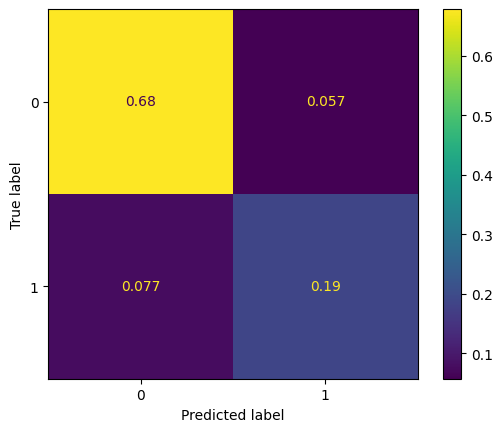

In [37]:
# Calculate confusion matrix
cm = confusion_matrix(labels_test, predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))
print(normalized_cm)
print()

# Plot the confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test, normalize = 'all')

## XGBoost: k-fold cross-validation

In [38]:
# Cross validate the model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)
results = cross_validate(model, features_train, labels_train, cv = kfold, return_train_score = True)

In [39]:
# Fit for real on all training data
model.fit(features_train, labels_train)

# Evaluate on test data
predictions = model.predict(features_test)
accuracy = accuracy_score(labels_test, predictions)

In [40]:
print('10-fold CV accuracy: %.2f%% (%.3f%%)' % (results['test_score'].mean() * 100, results['test_score'].std() * 100))
print('Hold out test set accuracy: %.2f%%' % (accuracy * 100.0))

10-fold CV accuracy: 88.26% (0.174%)
Hold out test set accuracy: 86.53%


OK, pretty good - we are not over-fitting or just guessing the major class, which is good. For reference, guessing human all the time would give us ~76% accuracy. Let's step it up and see if we can do better.

This turns out to be the best we have right now, so save it for later use.

In [41]:
from pickle import dump

output_file = config.XGB_CLASSIFIER

with open(output_file, 'wb') as file:
    dump(model, file, protocol = 5)

## XGBoost hyperparameter tuning

In [10]:
def hyperopt_cv(
      params: dict = None, 
      random_state: int = 42, 
      kfolds: int = 7,
      fold_split: float = 0.5,
      features: np.ndarray = None, 
      labels: np.ndarray = None
) -> float:
   
   '''Cross validate an XGBoost classifier with a set of hyperparameters, returns mean CV core'''
    
   # Get the a set of variable parameters from params
   params = {
      'eta': params['eta'],
      # 'gamma': params['gamma'],
      'max_depth': int(params['max_depth']),
      # 'min_child_weight': params['min_child_weight'],
      # 'max_delta_step': int(params['max_delta_step']),
      'subsample': int(params['subsample']),
      'reg_alpha' : params['reg_alpha'],
      'reg_lambda' : params['reg_lambda'],
      'n_estimators': int(params['n_estimators'])
   }

   # Create a new XGB model using the values from params
   model = xgboost.XGBClassifier(device = 'cuda', random_state = random_state, **params)

   # Get number of examples in dataset
   n = labels.shape[0]

   # Set score to zero at start
   score = 0

   # Run k-fold with random samples
   for k in range(kfolds):
      
      # Pick random indices without replacement for data to include in validation set
      validation_indices = np.random.choice(range(n), size = (int(n*fold_split),), replace = False)    
      validation_mask = np.zeros(n, dtype = bool)
      validation_mask[validation_indices] = True
      training_mask = ~validation_mask

      labels_train = labels[training_mask]
      features_train = features[training_mask]
      labels_validation = labels[validation_mask]
      features_validation = features[validation_mask]

      # Move data to GPU
      gpu_features_train = cp.array(features_train)
      gpu_labels_train = cp.array(labels_train)
      gpu_features_validation = cp.array(features_validation)
   
      # Fit the model
      model.fit(gpu_features_train, gpu_labels_train)

      # Make predictions for validation data
      labels_predicted = model.predict(gpu_features_validation)

      # Evaluate predictions, summing score across the folds
      score += accuracy_score(labels_validation, labels_predicted)

   # Return negated mean score for minimization
   return -score / kfolds

In [11]:
%%time

# How many iterations to run
n_iter = 200

# Fix random state
random_state = 42

# Parameter optimization space
space = {
       'eta': hp.uniform('eta', 0.001, 1.0),
       # 'gamma': hp.quniform('gamma', 0, 10, 1),
       'max_depth': hp.quniform('max_depth', 1, 50, 1),
       # 'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
       # 'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1),
       'subsample': hp.uniform('subsample', 0, 1),
       'reg_alpha': hp.quniform('reg_alpha', 0, 10, 1),
       'reg_lambda': hp.quniform('reg_lambda', 0, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 1, 50, 1)
}

# Set up trial logging
trials = Trials()

best = fmin(
       fn = partial(
              hyperopt_cv, 
              features = features_train, 
              labels = labels_train
       ),
       space = space,           # Parameter: value dictionary
       algo = tpe.suggest,      # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,      # Maximum number of iterations
       trials = trials,         # Logging
       rstate = np.random.default_rng(random_state)
)

print()

100%|██████████| 200/200 [01:33<00:00,  2.14trial/s, best loss: -0.7326545368689776]

CPU times: user 5min 4s, sys: 8.13 s, total: 5min 13s
Wall time: 1min 33s


In [29]:
print('Optimized parameters:')
print(f" Learning rate: {best['eta']}")
print(f" Max tree depth: {best['max_depth']}")
print(f" Estimators: {best['n_estimators']}")

# Fit on the complete training set with the winning parameters
model = xgboost.XGBClassifier(
    eta = best['eta'],
    # gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    # min_child_weight = best['min_child_weight'],
    # max_delta_step = int(best['max_delta_step']),
    subsample = best['subsample'],
    reg_alpha = best['reg_alpha'],
    reg_lambda = best['reg_lambda'],
    n_estimators = int(best['n_estimators']),
    random_state = random_state,
    device = 'cuda'
)

model.fit(cp.array(features_train), cp.array(labels_train))

# Evaluate on test data
labels_predicted = model.predict(cp.array(features_test))
accuracy = accuracy_score(labels_test, labels_predicted)

Optimized parameters:
 Learning rate: 0.5299596517686432
 Max tree depth: 27.0
 Estimators: 38.0


10-fold CV accuracy: 88.26% (0.174%)
Hold out test set accuracy: 85.97%

Confusion matrix:
[[16325  1486]
 [ 1909  4482]]

Normalized confusion matrix:
[[0.67453103 0.06139988]
 [0.07887778 0.18519131]]



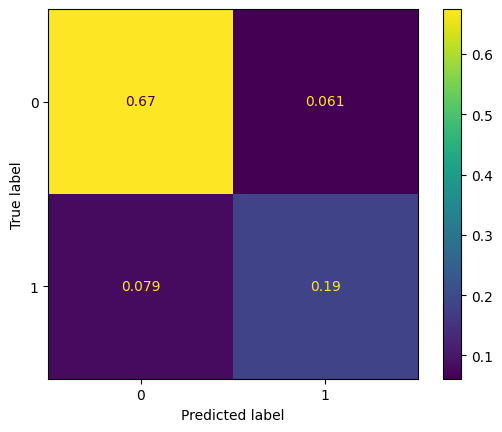

In [31]:
print('10-fold CV accuracy: %.2f%% (%.3f%%)' % (results['test_score'].mean() * 100, results['test_score'].std() * 100))
print('Hold out test set accuracy: %.2f%%' % (accuracy * 100.0))

# Calculate confusion matrix
cm = confusion_matrix(labels_test, labels_predicted)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))
print(normalized_cm)
print()

# Plot the confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(model, cp.array(features_test), labels_test, normalize = 'all')

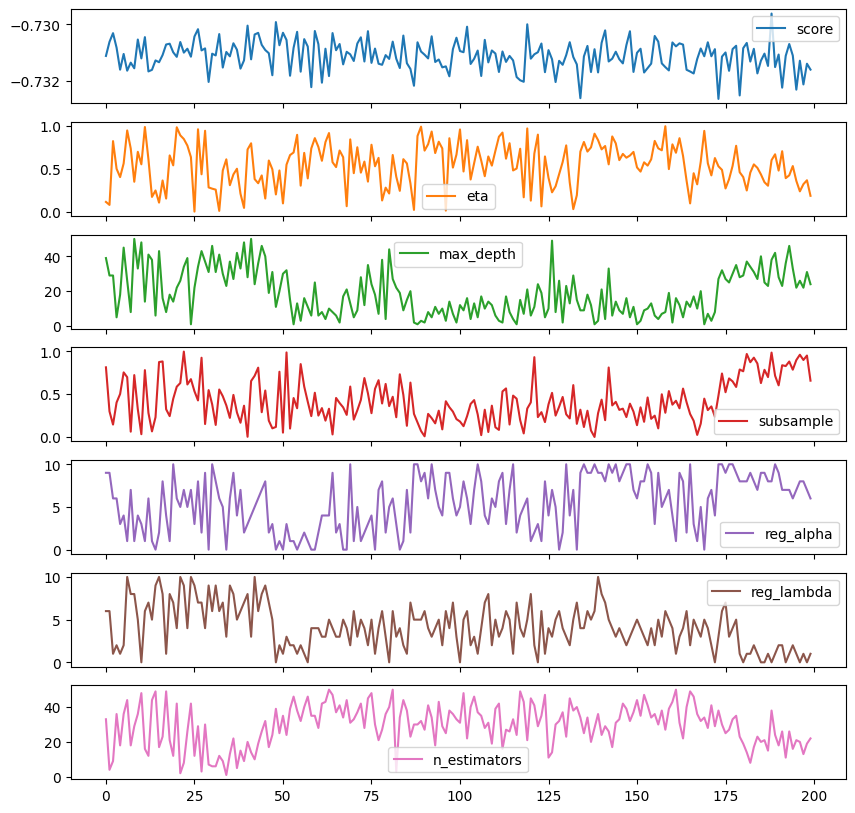

In [32]:
tpe_results = np.array([[
    x['result']['loss'],
    x['misc']['vals']['eta'][0],
    # x['misc']['vals']['gamma'][0],
    x['misc']['vals']['max_depth'][0],
    # x['misc']['vals']['min_child_weight'][0],
    # x['misc']['vals']['max_delta_step'][0],
    x['misc']['vals']['subsample'][0],
    x['misc']['vals']['reg_alpha'][0],
    x['misc']['vals']['reg_lambda'][0],
    x['misc']['vals']['n_estimators'][0],

] for x in trials.trials])

tpe_results_df = pd.DataFrame(
    tpe_results, 
    columns = [
        'score', 
        'eta',
        # 'gamma',
        'max_depth',
        # 'min_child_weight',
        # 'max_delta_step',
        'subsample',
        'reg_alpha',
        'reg_lambda',
        'n_estimators'
    ]
)

optimization_plot = tpe_results_df.plot(subplots = True, figsize = (10, 10))

## Where are we failing?

At this point, it feels like we have hit the limit of what the classifier is capable of. Doesn't seem like we will be able to get past 90% accuracy without changing/improving features and/or data. Let's take a look at the text fragments which are bing miss-classified and see if anything jumps out.

In [15]:
test_error_indices = []
i = 0
n = 1

for features, label, prediction in zip(features_test, labels_test, predictions):

    print(f'\nLabel = {label}, prediction = {prediction}', end = '')

    if label != prediction:
        print(' - error!', end = '')
        test_error_indices.append(i)

    n += 1
    i += 1

print(f'\nHave {len(test_error_indices)} ({round((len(test_error_indices) / len(labels_predicted)) * 100, 1)}%) miss-classed text fragments from the test set')


Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 1
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 1
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 1
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 1
Label = 1, prediction = 0 - error!
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 1 - error!
Label = 1, prediction = 1
Label = 0, prediction = 0
Label = 1, prediction = 0 - error!
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 1
Label = 1, prediction = 1
Label = 0, prediction = 0
Label = 1, prediction = 1
Label = 0, prediction = 0
Label = 1, prediction = 1
Label = 0, prediction = 0
Label = 0, prediction = 0
Label = 1, prediction = 1
Label = 0,

In [16]:
# Recover the miss-classed fragments
errors = []
test_strings = list(features_test_df['String'])

for i in test_error_indices:
    errors.append(test_strings[i])

for error in errors[:10]:
    print(f'{error}\n\n')

outdoors can help repel mosquitoes.
- Remove standing water. Mosquitoes breed in standing water. If you have a stagnant pool of water in your yard, the CDC recommends emptying it at least once a week, or keeping a water fountain filled with clean water to attract mosquitoes.
- Inspect yourself for ticks after being outside, and check your pets for ticks after they have been outside. Tick removal should always be done carefully, and with the use of tweezers. The CDC recommends that if you get a tick bite, keep the tick in a plastic bag to send to your state or local health department so they can test for any


in 2013.
PALACE was launched in 2010 by Lev Tanju. Since then, it has grown into one of the most sought-after independent British skateboard brands. The line has rapidly extended its reach beyond the skate community and counts artists A$AP Rocky, Jay-Z, and Drake as fans.
StockX was founded by Luber, StockX COO Greg Schwartz, and Dan Gilbert, founder and chairman of Quicken Loans 

Hmm, hard to draw any easy conclusions why these are being miss-classified. Some are short or very low entropy, but many are not. Maybe let's look at our features' distributions in the correctly and incorrectly classed fragments.

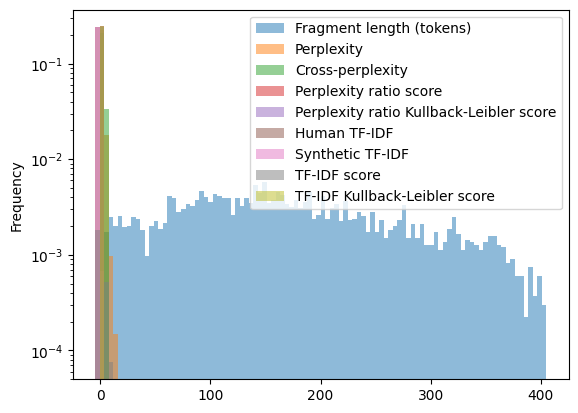

In [17]:
errors = features_test_df.iloc[test_error_indices]
ax = errors.plot.hist(bins=100, alpha=0.5, density=True, log=True)

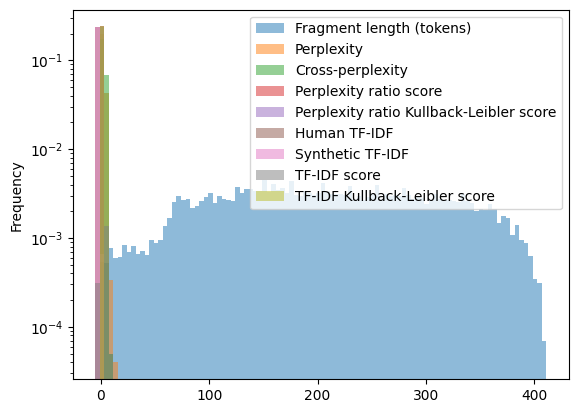

In [18]:
ax = features_test_df.plot.hist(bins=100, alpha=0.5, density=True, log=True)

Yeah, nothing jumps right out at me... Maybe let's just do some general feature checking.

<Figure size 1900x1500 with 0 Axes>

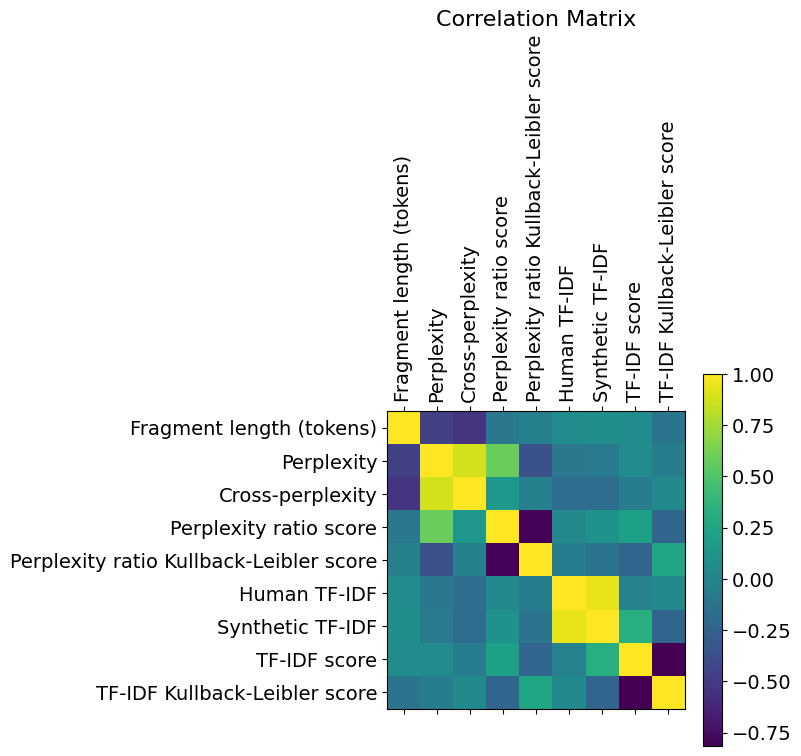

In [19]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(features_test_df.drop(['String', 'Dataset'], axis = 1).corr())
plt.xticks(range(features_test_df.select_dtypes(['number']).shape[1]), features_test_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(features_test_df.select_dtypes(['number']).shape[1]), features_test_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

OK, so we do have some strongly correlated and anti-correlated features. Let's try just removing some of them and see if things improve.

In [20]:
features_train_df.head()

,Fragment length (tokens),Dataset,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score
0,179,pubmed-falcon7,"\n age , sex , final education , the average m...",2.549562,2.746482,0.928301,0.249962,-2.639094,-2.541294,0.506643,0.103827
1,227,cnn-llama2-13,we are seeing this season is a far cry from th...,2.594488,3.453265,0.751314,1.482401,-3.447403,-3.272191,1.177354,0.047752
2,244,cnn-llama2-13,been performed for thousands of years. In some...,2.951859,3.093754,0.954135,0.144317,-3.362655,-3.035911,2.090690,0.030318
3,178,cc_news-llama2-13,or machinations in the 2016 campaign as ground...,2.474184,3.026876,0.817405,1.516302,-3.206865,-3.077414,0.813506,0.077268
4,173,pubmed-llama2-13,progenitor cell and one postmitotic neuron ....,2.665275,2.825413,0.943322,0.177392,-3.182795,-2.988648,1.198170,0.046413


<Figure size 1900x1500 with 0 Axes>

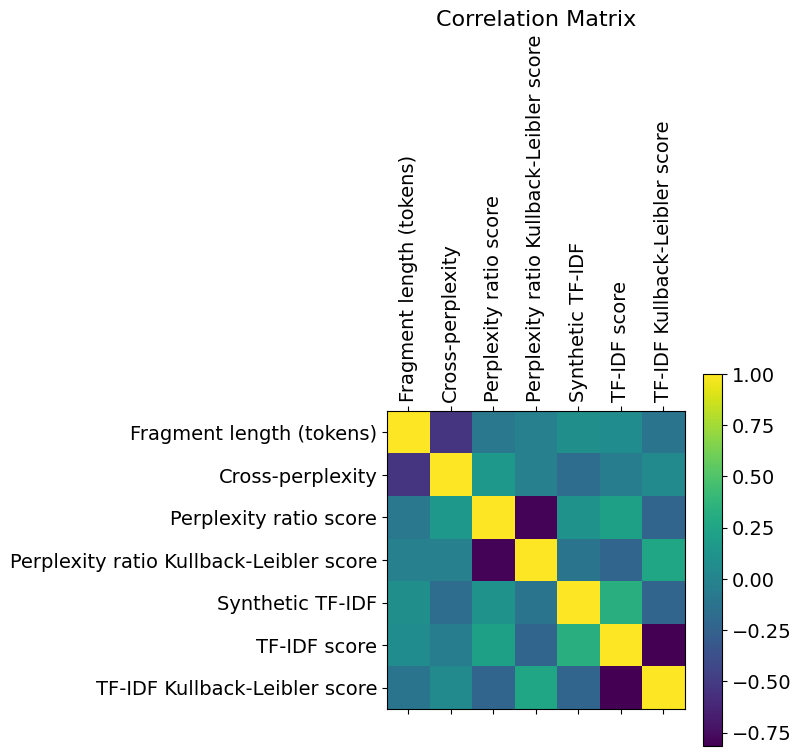

In [21]:
drops = ['Dataset', 'String', 'Perplexity', 'Human TF-IDF'] #, 'Perplexity ratio score', 'TF-IDF score', 'Synthetic TF-IDF', 'Cross-perplexity']

trimmed_features_train_df = features_train_df.drop(drops, axis = 1)
trimmed_features_test_df = features_test_df.drop(drops, axis = 1)

f = plt.figure(figsize=(19, 15))
plt.matshow(trimmed_features_test_df.corr())
plt.xticks(range(trimmed_features_test_df.select_dtypes(['number']).shape[1]), trimmed_features_test_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(trimmed_features_test_df.select_dtypes(['number']).shape[1]), trimmed_features_test_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [22]:
# Fit model on training data
model = xgboost.XGBClassifier()
model.fit(trimmed_features_train_df, labels_train)

# Make predictions for test data
y_pred = model.predict(trimmed_features_test_df)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 86.7%


Eh, dropping features doesn't make things convincingly better. Let's try some crack-head stuff, "y'all got any more of them features?"

In [23]:
features = ['Perplexity', 'Cross-perplexity', 'Perplexity ratio score', 'Perplexity ratio Kullback-Leibler score', 'Human TF-IDF', 'Synthetic TF-IDF', 'TF-IDF score', 'TF-IDF Kullback-Leibler score']

for feature in features:
    synthetic_feature = f'{feature} squared'
    training_data_df[synthetic_feature] = training_data_df[feature] ** 2
    testing_data_df[synthetic_feature] = training_data_df[feature] ** 2

training_data_df.head()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score,Perplexity squared,Cross-perplexity squared,Perplexity ratio score squared,Perplexity ratio Kullback-Leibler score squared,Human TF-IDF squared,Synthetic TF-IDF squared,TF-IDF score squared,TF-IDF Kullback-Leibler score squared
0,179,pubmed-falcon7,human,"\n age , sex , final education , the average m...",2.549562,2.746482,0.928301,0.249962,-2.639094,-2.541294,0.506643,0.103827,6.500266,7.543162,0.861743,0.062481,6.964819,6.458176,0.256687,0.010780
1,227,cnn-llama2-13,synthetic,we are seeing this season is a far cry from th...,2.594488,3.453265,0.751314,1.482401,-3.447403,-3.272191,1.177354,0.047752,6.731368,11.925041,0.564473,2.197512,11.884590,10.707237,1.386162,0.002280
2,244,cnn-llama2-13,human,been performed for thousands of years. In some...,2.951859,3.093754,0.954135,0.144317,-3.362655,-3.035911,2.090690,0.030318,8.713469,9.571314,0.910373,0.020827,11.307447,9.216757,4.370986,0.000919
3,178,cc_news-llama2-13,human,or machinations in the 2016 campaign as ground...,2.474184,3.026876,0.817405,1.516302,-3.206865,-3.077414,0.813506,0.077268,6.121589,9.161978,0.668151,2.299171,10.283983,9.470478,0.661792,0.005970
4,173,pubmed-llama2-13,human,progenitor cell and one postmitotic neuron ....,2.665275,2.825413,0.943322,0.177392,-3.182795,-2.988648,1.198170,0.046413,7.103689,7.982959,0.889857,0.031468,10.130186,8.932016,1.435611,0.002154


In [24]:
features_train = features_train_df.drop(['Dataset', 'String'], axis = 1).to_numpy()
features_test = features_test_df.drop(['Dataset', 'String'], axis = 1).to_numpy()

In [25]:
# Fit model on training data
model = xgboost.XGBClassifier()
model.fit(features_train, labels_train)

# Make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 86.5%


OK, apparently sklearn has this built in...

In [26]:
# demonstrate the types of features created
from numpy import asarray
from sklearn.preprocessing import PolynomialFeatures

# Load the raw training and testing data
training_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF)
testing_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TESTING_DATA_PR_TFIDF)

percent_human_fragments = (len(training_data_df[training_data_df['Source'] == 'human']) / len(training_data_df)) * 100
print(f'Text fragments are {percent_human_fragments}% human\n')

training_data_df.info()
print()
training_data_df.head()

# Split the data into features and labels
labels_train_df = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)
labels_test_df = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train_df)
labels_train = label_encoder.transform(labels_train_df)

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_test_df)
labels_test = label_encoder.transform(labels_test_df)

# Keep dataframe copy for easy manipulation later and make a numpy copy for training
# without the dataset or string columns
features_train = features_train_df.drop(['Dataset', 'String'], axis = 1).to_numpy()
features_test = features_test_df.drop(['Dataset', 'String'], axis = 1).to_numpy()
# labels_train = labels_train_df.to_numpy()
# labels_test = labels_test_df.to_numpy()

print(f'Training data: {len(features_train)} examples')
print(f'Test data: {len(features_test)} examples')
print()
print('Training features:')
print(features_train_df.info())
print()
print('Training labels:')
print(labels_train)

# perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree = 3)
poly_features_train = trans.fit_transform(features_train)
poly_features_test = trans.fit_transform(features_test)


Text fragments are 73.11331474021279% human

<class 'pandas.core.frame.DataFrame'>
Index: 96810 entries, 0 to 96809
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (tokens)                 96810 non-null  int64  
 1   Dataset                                  96810 non-null  object 
 2   Source                                   96810 non-null  object 
 3   String                                   96810 non-null  object 
 4   Perplexity                               96810 non-null  float64
 5   Cross-perplexity                         96810 non-null  float64
 6   Perplexity ratio score                   96810 non-null  float64
 7   Perplexity ratio Kullback-Leibler score  96810 non-null  float64
 8   Human TF-IDF                             96810 non-null  float64
 9   Synthetic TF-IDF                         96810 non-null  float64
 10  TF-IDF

In [27]:
# Fit model on training data
model = xgboost.XGBClassifier(device = 'cuda')
model.fit(cp.array(poly_features_train), cp.array(labels_train))

# Make predictions for test data
y_pred = model.predict(cp.array(poly_features_test))
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 86.6%


Nope, OK, need to move on here. Looks like there is no easy way to improve... We can revisit this later.